# CNN
A notebook to implement CNNs (i.e. Resnet-34)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Tensorflow is required
import tensorflow as tf
import tensorflow_datasets as tfds
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd
import numpy as np
import os
PRJ_ROOT_DIR = os.path.dirname(os.path.abspath(''))

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

In [2]:
# Where to save the figures
NOTE_ROOT_DIR = os.path.abspath('')
CHAPTER_ID = "01_cnn"
IMAGES_PATH = os.path.join(NOTE_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1 - Load the Data

In [3]:
# Load the flower dataset
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

Saving figure flowers_with_label


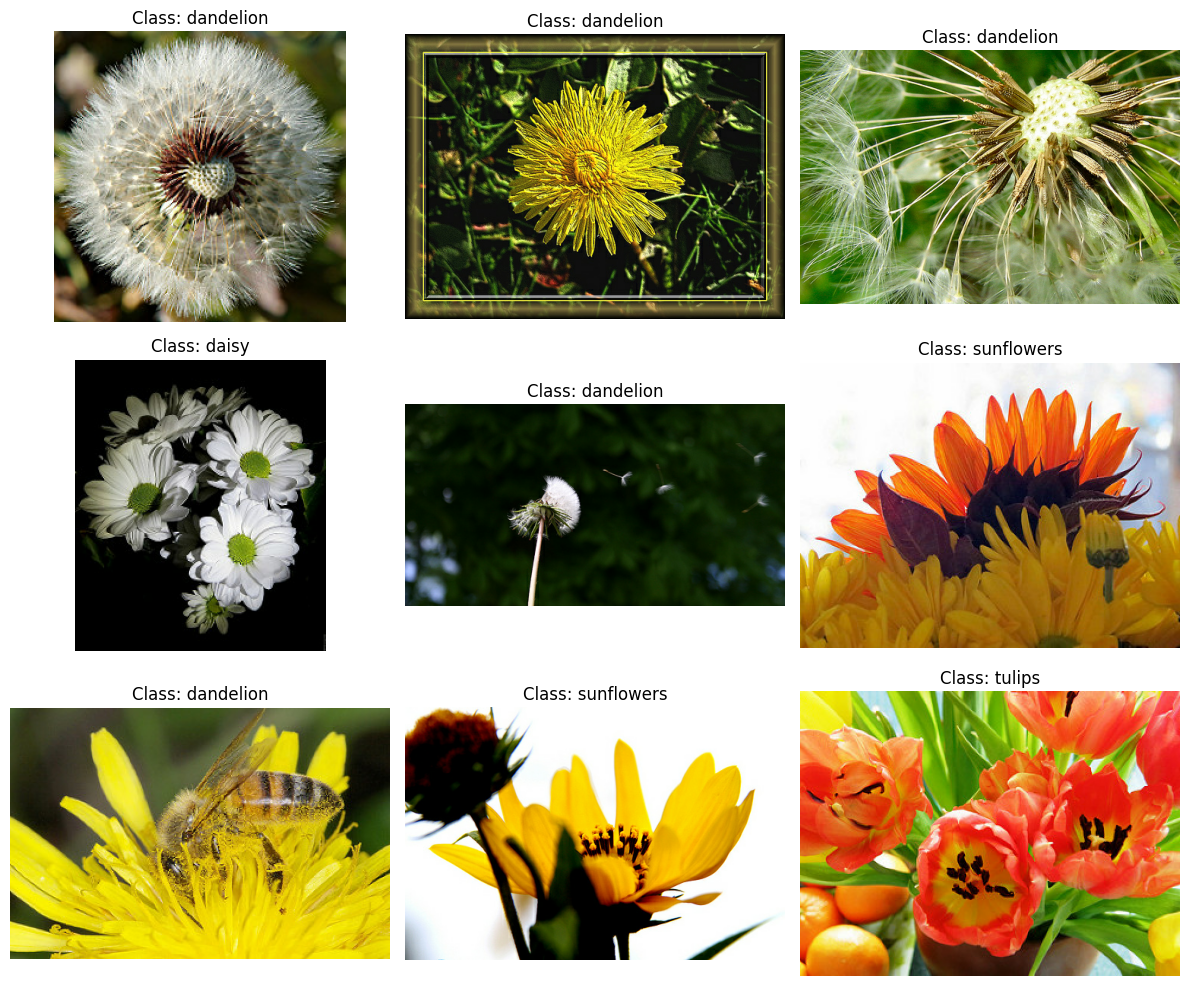

In [4]:
# Plot some instances 
class_names = ["dandelion", "daisy", "tulips", "sunflowers", "roses"]
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
save_fig("flowers_with_label")

In [4]:
# Preprocess and split the dataset
from models import preprocess
from functools import partial

class_names = ["dandelion", "daisy", "tulips", "sunflowers", "roses"]
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Saving figure flowers_with_label_preprocessed


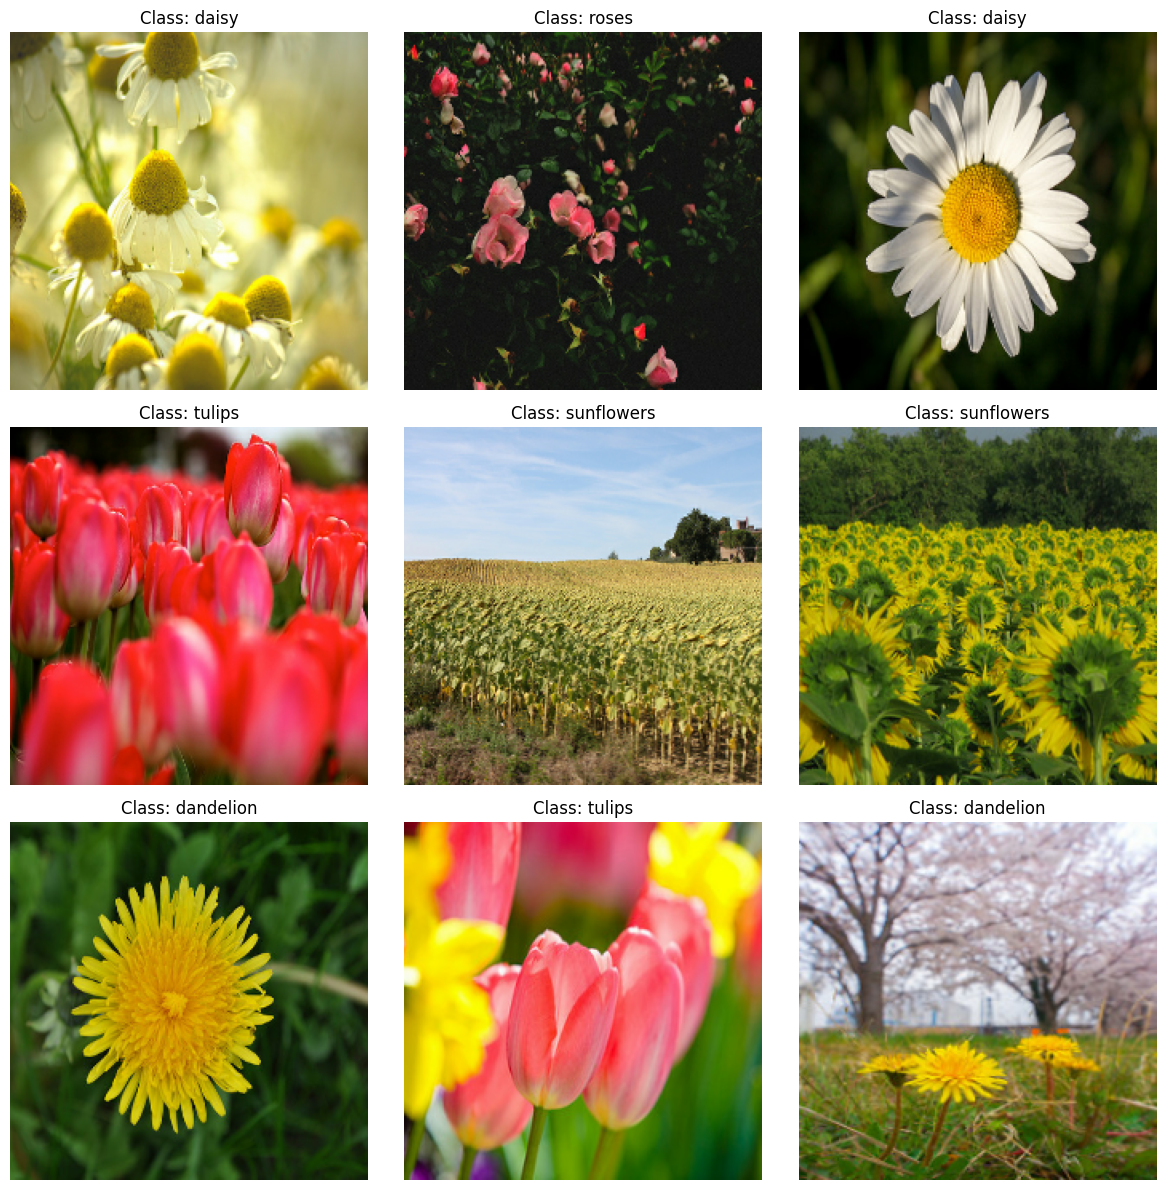

In [6]:
# Plot some instances preprocessed
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
save_fig("flowers_with_label_preprocessed")

## 2 - Model

In [6]:
# Build Resnet-34
from models import DefaultConv2D, ResidualUnit
from tensorflow import keras

model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [7]:
# Test the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                        

### Training

In [12]:
# Train the model
dataset_size = len(train_set_raw)
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
64/64 [==============================] - 319s 5s/step - loss: 4.4231 - accuracy: 0.2427 - val_loss: 2111514.5000 - val_accuracy: 0.1745
Epoch 2/5
64/64 [==============================] - 333s 5s/step - loss: 1.6074 - accuracy: 0.2686 - val_loss: 284.1183 - val_accuracy: 0.2292
Epoch 3/5
64/64 [==============================] - 312s 5s/step - loss: 1.5655 - accuracy: 0.2661 - val_loss: 10.7201 - val_accuracy: 0.2812
Epoch 4/5
64/64 [==============================] - 301s 5s/step - loss: 1.4919 - accuracy: 0.3281 - val_loss: 2.5447 - val_accuracy: 0.2786
Epoch 5/5
64/64 [==============================] - 300s 5s/step - loss: 1.4770 - accuracy: 0.3174 - val_loss: 1.8122 - val_accuracy: 0.2786


### Testing

In [13]:
# Evaluate the model
model.evaluate(test_set, batch_size=32)

12/12 [==============================] - 7s 611ms/step - loss: 1.7405 - accuracy: 0.2561


[1.740474820137024, 0.25613078474998474]